Nick Clifford

# Word Embeddings: Word2Vec

# Set Up

In [1]:
OHCO = ['author', 'doc_id', 'page_num', 'para_num', 'sent_num', 'token_num']
BAG = OHCO[:4] # Paragraphs
# BAG = OHCO[:5] # Sentences
window = 5

## Imports

In [2]:
import numpy as np
import pandas as pd
import plotly_express as px
from sklearn.manifold import TSNE
from gensim.models import word2vec

In [3]:
%matplotlib inline

In [4]:
datadir = '/Users/nickclifford/Documents/UVA/Spring 2020/DS 5001 Exploratory Text Analysis/final/data/'
table_out = datadir + 'tables/'

LIB = pd.read_csv(datadir + 'tables/LIB_mod.csv', parse_dates=['date']).set_index('doc_id')
TOKEN = pd.read_csv(datadir + 'tables/TOKEN_mod.csv').set_index('doc_id')
VOCAB = pd.read_csv(datadir + 'tables/VOCAB_mod.csv').set_index('term_id')

# Corpus -> Gensim -> TSNE

Merge author, county, and date fields to `TOKEN` table, then bag to make a corpus. Use gensim library to make word2vec model, vectorize terms, and visualize them using TSNE.

In [5]:
TOKEN = TOKEN.merge(LIB[['author', 'county', 'date']], left_index=True, right_index=True)\
.reset_index().set_index(OHCO)
TOKEN.head()

pos_tuple  \
author          doc_id page_num para_num sent_num token_num                       
L. M. Blackford A0001  1        9        0        0               ('He', 'PRP')   
                                                  1              ('Qrs', 'NNP')   
                                         1        0          ('Military', 'JJ')   
                                                  1            ('Court', 'NNP')   
                                                  3               ('1st', 'CD')   

                                                             pos token_str  \
author          doc_id page_num para_num sent_num token_num                  
L. M. Blackford A0001  1        9        0        0          PRP        He   
                                                  1          NNP       Qrs   
                                         1        0           JJ  Military   
                                                  1          NNP     Court   
                                                  3           CD       1st   

                                                             term_str  \
author          doc_id page_num para_num sent_num token_num             
L. M. Blackford A0001  1        9        0        0                he   
                                                  1               qrs   
                                         1        0          military   
                                                  1             court   
                                                  3               1st   

                                                             term_id  \
author          doc_id page_num para_num sent_num token_num            
L. M. Blackford A0001  1        9        0        0            10290   
                                                  1            17261   
                                         1        0            14109   
                                                  1             5413   
                                                  3              226   

                                                            stem_porter  \
author          doc_id page_num para_num sent_num token_num               
L. M. Blackford A0001  1        9        0        0                  he   
                                                  1                  qr   
                                         1        0            militari   
                                                  1               court   
                                                  3                 1st   

                                                              county  \
author          doc_id page_num para_num sent_num token_num            
L. M. Blackford A0001  1        9        0        0          Augusta   
                                                  1          Augusta   
                                         1        0          Augusta   
                                                  1          Augusta   
                                                  3          Augusta   

                                                                  date  
author          doc_id page_num para_num sent_num token_num             
L. M. Blackford A0001  1        9        0        0         1863-06-28  
                                                  1         1863-06-28  
                                         1        0         1863-06-28  
                                                  1         1863-06-28  
                                                  3         1863-06-28

In [6]:
def get_wordembedding(TOKEN, BAG, nnp=False):
    """From TOKEN table and bagging specification, return a Gensim word2vec model and
    visualize the semantic space using a TSNE plot"""
    
    def plot_tsne(coords):
        px.scatter(coords, 'x', 'y', text='label', height=1000).update_traces(mode='text')
    
    if nnp:
        corpus = TOKEN\
            .groupby(BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()    
    else:
        corpus = TOKEN[~TOKEN.pos.str.match('NNPS?')]\
            .groupby(BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()    
        
    # Get wordembeddings
    model = word2vec.Word2Vec(corpus, size=246, window=window, min_count=200, workers=4)
    
    return model
    
def plot_tsne(model, title):
    """Visualizes TSNE plot based on a word2vec model"""
    
    # Generate Coordinates
    coords = pd.DataFrame(index=range(len(model.wv.vocab)))
    coords['label'] = [w for w in model.wv.vocab]
    coords['vector'] = coords['label'].apply(lambda x: model.wv.get_vector(x))
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_values = tsne_model.fit_transform(coords['vector'].tolist())

    coords['x'] = tsne_values[:,0]
    coords['y'] = tsne_values[:,1]
    
    return px.scatter(coords, 'x', 'y', text='label', title=title, height=1000).update_traces(mode='text')

In [7]:
model_para = get_wordembedding(TOKEN, OHCO[:4], nnp=True)

In [8]:
model_sent = get_wordembedding(TOKEN, OHCO[:5], nnp=False)

# Plot TSNE 

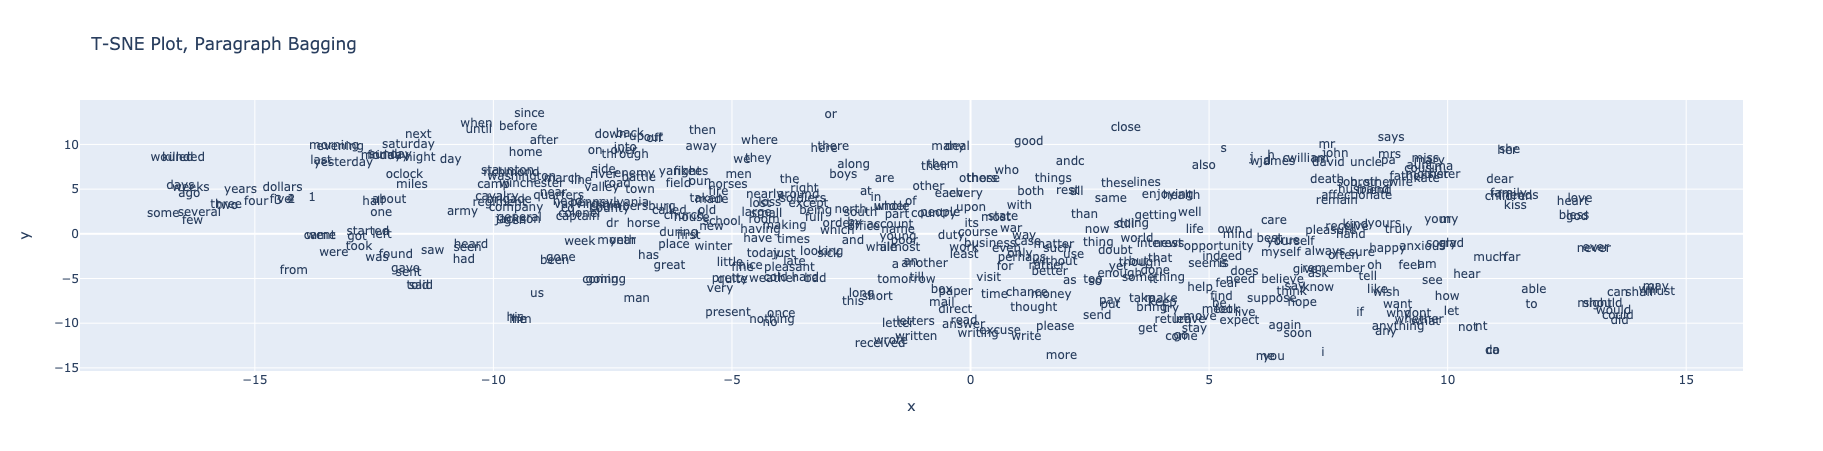

In [127]:
plot_tsne(model_para, title='T-SNE Plot, Paragraph Bagging')

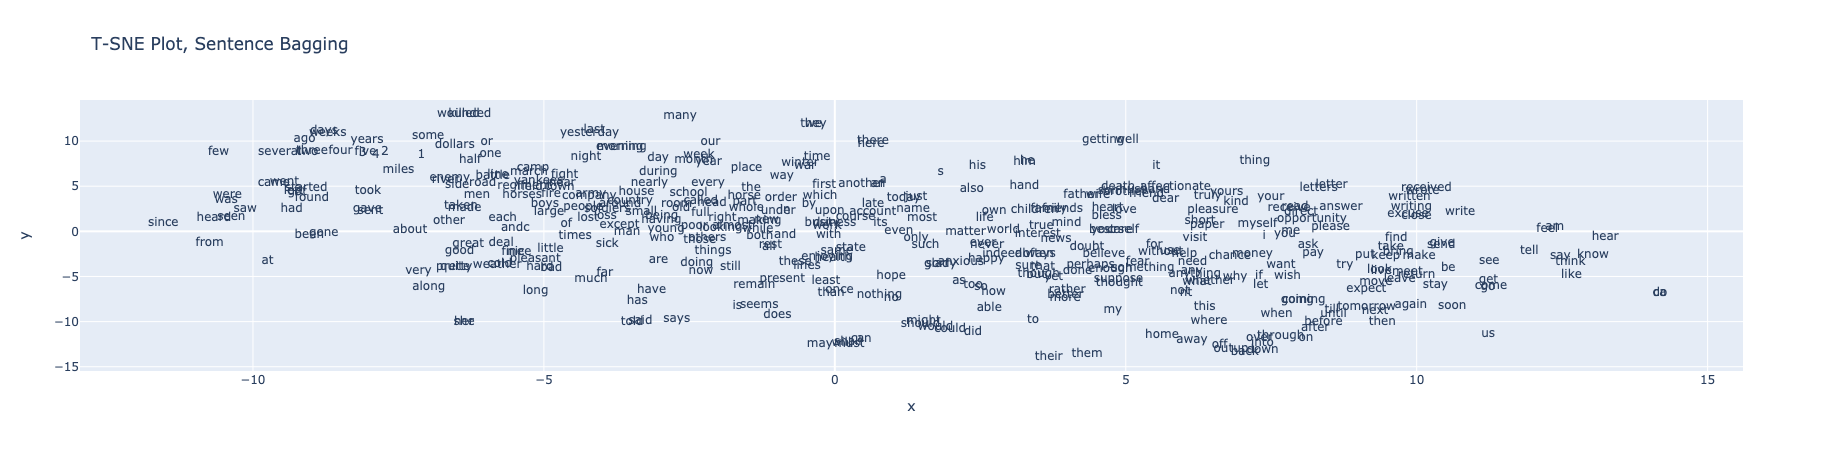

In [119]:
plot_tsne(model_sent, title='T-SNE Plot, Sentence Bagging')

# Semantic Algebra

In [88]:
def complete_analogy(model, A, B, C, n=2):
    """Completes an analogy using the values of the words in semantic space:
    A : B :: C : D?  --> B - A + C = D"""
    try:
        return model.wv.most_similar(positive=[B, C], negative=[A])[0:n]
    except KeyError as e:
        print('Error:', e)
        return None

In [143]:
complete_analogy(model_para, 'husband', 'wife', 'men', n=5)

[('horses', 0.7706892490386963),
 ('around', 0.7091395258903503),
 ('right', 0.6365718841552734),
 ('lost', 0.6359282732009888),
 ('regiment', 0.6325278878211975)]

In [97]:
complete_analogy(model_para, 'north', 'yankees', 'south', n=5)

[('river', 0.8490810394287109),
 ('valley', 0.7954615354537964),
 ('enemy', 0.7943211793899536),
 ('road', 0.7822015285491943),
 ('cavalry', 0.7599822878837585)]

In [95]:
complete_analogy(model_para, 'north', 'south', 'friend', n=5)

[('husband', 0.8584264516830444),
 ('son', 0.8233444690704346),
 ('affectionate', 0.8196940422058105),
 ('sir', 0.7831145524978638),
 ('brother', 0.7828435897827148)]

In [137]:
complete_analogy(model_para, 'south', 'richmond', 'north', n=10)

[('washington', 0.7713349461555481),
 ('winchester', 0.7580994963645935),
 ('staunton', 0.7467986345291138),
 ('back', 0.6672949194908142),
 ('town', 0.6391319036483765),
 ('church', 0.6296826601028442),
 ('yankees', 0.6138702630996704),
 ('march', 0.6098120808601379),
 ('valley', 0.5917113423347473),
 ('off', 0.5906294584274292)]

In [142]:
complete_analogy(model_para, 'cold', 'sick', 'battle', n=10)

[('wounded', 0.7931150197982788),
 ('killed', 0.7893164157867432),
 ('taken', 0.6635701656341553),
 ('regiment', 0.6535887718200684),
 ('chambersburg', 0.6444414258003235),
 ('cavalry', 0.6436634063720703),
 ('yankees', 0.6329777240753174),
 ('field', 0.6307801604270935),
 ('called', 0.6108852624893188),
 ('men', 0.5999621152877808)]

# Analysis

I think it is necessary to include the pronouns in the corpus, since it includes important geographic locations related to the civil war and the counties (washington, staunton, richmond). 

tsne_para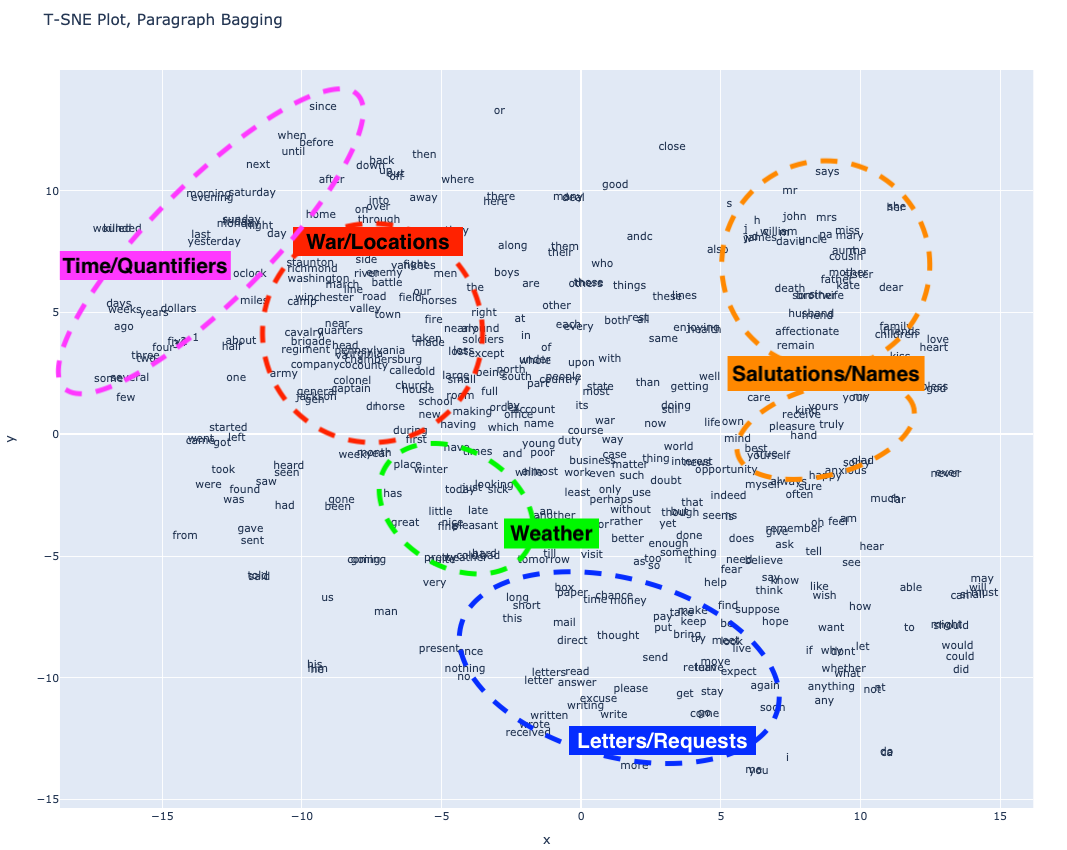